In [2]:
# Import all libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [3]:
# Define emotion labels based on your mapping
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

# Load and Preprocess RAF-DB Dataset
class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # RAF-DB classes: 1=Surprise, 2=Fear, 3=Disgust, 4=Happy, 5=Sad, 6=Anger, 7=Neutral
        # Desired mapping: Happy=0, Surprise=1, Sad=2, Anger=3, Disgust=4, Fear=5, Neutral=6
        self.label_map = {1: 1, 2: 5, 3: 4, 4: 0, 5: 2, 6: 3, 7: 6}

        # Dynamically load images and labels from folder structure
        self.image_data = []
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)  # Get RAF-DB label (1-7) from folder name
                if label in self.label_map:
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            self.image_data.append([filename, label])

        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_rafdb_label = self.image_data[idx]
        # Map RAF-DB label (1-7) to desired label (0-6)
        mapped_label = self.label_map[original_rafdb_label]
        # Construct image path using the original RAF-DB label (folder name)
        img_path = os.path.join(self.img_dir, str(original_rafdb_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

# Define enhanced transforms for training with additional augmentations
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define minimal transforms for testing
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
base_path = "/kaggle/input/raf-db-dataset"
train_img_dir = os.path.join(base_path, "DATASET/train")
test_img_dir = os.path.join(base_path, "DATASET/test")

if not os.path.exists(train_img_dir):
    print(f"Warning: Training image directory not found at {train_img_dir}")
if not os.path.exists(test_img_dir):
    print(f"Warning: Test image directory not found at {test_img_dir}")

# Load full training dataset with train transforms (for now)
full_train_dataset = RAFDBDataset(img_dir=train_img_dir, transform=train_transforms)

# Split into train and validation (80% train, 20% val)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply test transforms to validation set
val_dataset.dataset.transform = test_transforms  # override transform for validation subset

# Load test dataset
test_dataset = RAFDBDataset(img_dir=test_img_dir, transform=test_transforms)

# Dataset size info
print(f"Total Training Data: {len(full_train_dataset)}")
print(f"Training Split: {len(train_dataset)}")
print(f"Validation Split: {len(val_dataset)}")
print(f"Test Set: {len(test_dataset)}")

# Class distribution (based on original full training data)
train_original_labels = [item[1] for item in full_train_dataset.image_data]
train_class_counts = pd.Series(train_original_labels).value_counts().sort_index()
print("\nTraining set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):")
for original_label, count in train_class_counts.items():
    mapped_label = full_train_dataset.label_map[original_label]
    emotion_name = emotion_labels[mapped_label]
    print(f"Original Class {original_label} ({emotion_name}): {count} images")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Batch shape check
train_image, train_label = next(iter(train_loader))
print(f"\nTrain batch: Image shape {train_image.shape}, Label shape {train_label.shape}")

val_image, val_label = next(iter(val_loader))
print(f"Validation batch: Image shape {val_image.shape}, Label shape {val_label.shape}")

test_image, test_label = next(iter(test_loader))
print(f"Test batch: Image shape {test_image.shape}, Label shape {test_label.shape}")

Total Training Data: 12271
Training Split: 9816
Validation Split: 2455
Test Set: 3068

Training set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):
Original Class 1 (Surprise): 1290 images
Original Class 2 (Fear): 281 images
Original Class 3 (Disgust): 717 images
Original Class 4 (Happy): 4772 images
Original Class 5 (Sad): 1982 images
Original Class 6 (Anger): 705 images
Original Class 7 (Neutral): 2524 images

Train batch: Image shape torch.Size([32, 3, 64, 64]), Label shape torch.Size([32])
Validation batch: Image shape torch.Size([32, 3, 64, 64]), Label shape torch.Size([32])
Test batch: Image shape torch.Size([32, 3, 64, 64]), Label shape torch.Size([32])


Number of images processed in this batch: 32
Number of images displayed: 8


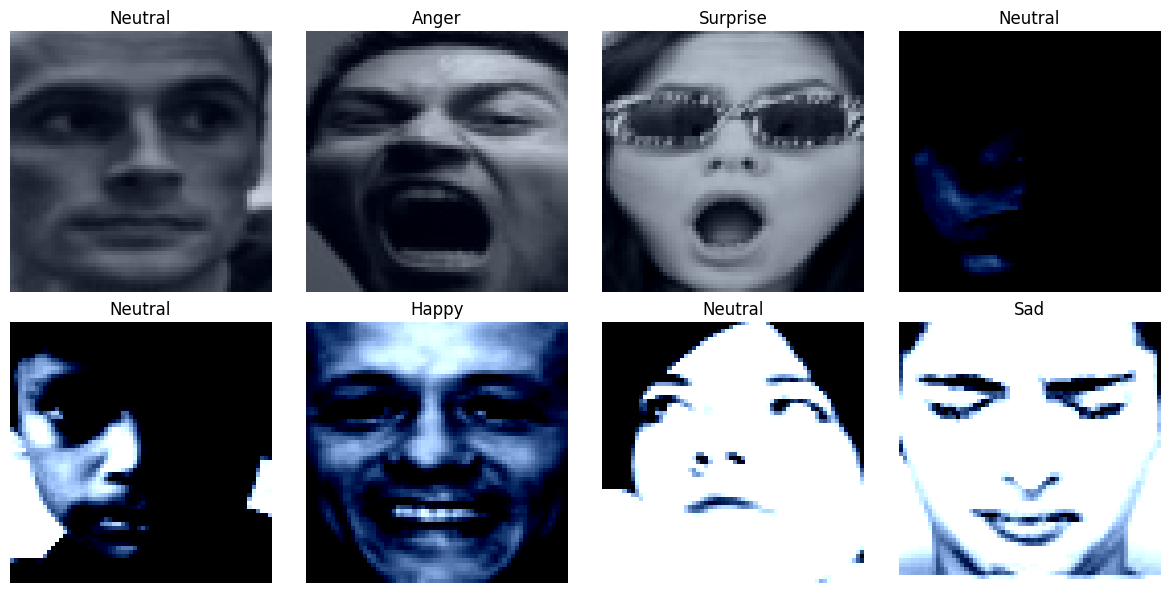

In [4]:
# After augmentation
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (tensor * std) + mean
    return tensor

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize images for visualization
images = denormalize(images)

# Print the number of images in the batch
print(f"Number of images processed in this batch: {images.shape[0]}")
print(f"Number of images displayed: 8")

# Plot the first 8 images in the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
    axes[i].imshow(img)  # Since images are grayscale with 3 channels, this will show as grayscale
    axes[i].set_title(emotion_labels[labels[i].item()])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
# ResidualBlock Block   
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
# Define ResEmoteNet
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)
        
        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Device, model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResEmoteNet().to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} Total Parameters.")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

# Checkpoint logic
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_acc = 0.0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Load checkpoint if available
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_acc = checkpoint.get('best_acc', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accs = checkpoint.get('train_accs', [])
    val_accs = checkpoint.get('val_accs', [])
    print(f"Resumed training from epoch {start_epoch} with best accuracy {best_acc:.2f}%")

In [ ]:
patience = 5
epochs_no_improve = 0
early_stop = False
num_epochs = 60

best_model_path = "/kaggle/working/best_model.pth"
last_checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

for epoch in range(start_epoch, num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for batch_idx, (images, labels) in train_progress:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_progress.set_postfix({'loss': running_loss / (batch_idx + 1)})

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for batch_idx, (images, labels) in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress.set_postfix({'loss': val_running_loss / (batch_idx + 1)})

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # --- Print epoch summary ---
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    # --- Save checkpoint ---
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    torch.save(checkpoint, last_checkpoint_path)

    # --- Save best model ---
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Val Acc: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Val Acc for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

Epoch 1/30 [Training]: 100%|██████████| 307/307 [02:03<00:00,  2.48it/s, loss=1.89]


Epoch [1/30]
  Train Loss: 1.8927, Train Acc: 28.73%
  Val   Loss: 1.8192, Val   Acc: 40.33%
New best model saved with Val Acc: 40.33%


Epoch 2/30 [Training]: 100%|██████████| 307/307 [00:51<00:00,  5.96it/s, loss=1.75]


Epoch [2/30]
  Train Loss: 1.7465, Train Acc: 38.41%
  Val   Loss: 1.6313, Val   Acc: 40.33%
No improvement in Val Acc for 1 epoch(s).


Epoch 3/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.70it/s, loss=1.65]


Epoch [3/30]
  Train Loss: 1.6505, Train Acc: 38.52%
  Val   Loss: 1.5867, Val   Acc: 40.33%
No improvement in Val Acc for 2 epoch(s).


Epoch 4/30 [Training]: 100%|██████████| 307/307 [00:54<00:00,  5.67it/s, loss=1.62]


Epoch [4/30]
  Train Loss: 1.6166, Train Acc: 38.51%
  Val   Loss: 1.5651, Val   Acc: 40.33%
No improvement in Val Acc for 3 epoch(s).


Epoch 5/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.72it/s, loss=1.58]


Epoch [5/30]
  Train Loss: 1.5832, Train Acc: 38.67%
  Val   Loss: 1.5324, Val   Acc: 40.33%
No improvement in Val Acc for 4 epoch(s).


Epoch 6/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.75it/s, loss=1.53]


Epoch [6/30]
  Train Loss: 1.5314, Train Acc: 39.11%
  Val   Loss: 1.4824, Val   Acc: 40.37%
New best model saved with Val Acc: 40.37%


Epoch 7/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.74it/s, loss=1.48]


Epoch [7/30]
  Train Loss: 1.4766, Train Acc: 40.41%
  Val   Loss: 1.4269, Val   Acc: 42.81%
New best model saved with Val Acc: 42.81%


Epoch 8/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.74it/s, loss=1.44]


Epoch [8/30]
  Train Loss: 1.4389, Train Acc: 43.26%
  Val   Loss: 1.3979, Val   Acc: 46.56%
New best model saved with Val Acc: 46.56%


Epoch 9/30 [Training]: 100%|██████████| 307/307 [00:54<00:00,  5.66it/s, loss=1.41]


Epoch [9/30]
  Train Loss: 1.4098, Train Acc: 45.79%
  Val   Loss: 1.3594, Val   Acc: 50.96%
New best model saved with Val Acc: 50.96%


Epoch 10/30 [Training]: 100%|██████████| 307/307 [00:54<00:00,  5.66it/s, loss=1.37]


Epoch [10/30]
  Train Loss: 1.3716, Train Acc: 48.76%
  Val   Loss: 1.3376, Val   Acc: 52.02%
New best model saved with Val Acc: 52.02%


Epoch 11/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.76it/s, loss=1.35]


Epoch [11/30]
  Train Loss: 1.3461, Train Acc: 49.69%
  Val   Loss: 1.3170, Val   Acc: 52.67%
New best model saved with Val Acc: 52.67%


Epoch 12/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.74it/s, loss=1.32]


Epoch [12/30]
  Train Loss: 1.3205, Train Acc: 50.80%
  Val   Loss: 1.3073, Val   Acc: 52.95%
New best model saved with Val Acc: 52.95%


Epoch 13/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.85it/s, loss=1.3] 


Epoch [13/30]
  Train Loss: 1.2990, Train Acc: 51.13%
  Val   Loss: 1.2730, Val   Acc: 53.60%
New best model saved with Val Acc: 53.60%


Epoch 14/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.80it/s, loss=1.28]


Epoch [14/30]
  Train Loss: 1.2774, Train Acc: 51.93%
  Val   Loss: 1.2517, Val   Acc: 54.05%
New best model saved with Val Acc: 54.05%


Epoch 15/30 [Training]: 100%|██████████| 307/307 [00:51<00:00,  5.91it/s, loss=1.26]


Epoch [15/30]
  Train Loss: 1.2630, Train Acc: 52.56%
  Val   Loss: 1.2498, Val   Acc: 53.60%
No improvement in Val Acc for 1 epoch(s).


Epoch 16/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.80it/s, loss=1.24]


Epoch [16/30]
  Train Loss: 1.2424, Train Acc: 52.87%
  Val   Loss: 1.2346, Val   Acc: 54.58%
New best model saved with Val Acc: 54.58%


Epoch 17/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.86it/s, loss=1.22]


Epoch [17/30]
  Train Loss: 1.2171, Train Acc: 53.77%
  Val   Loss: 1.2134, Val   Acc: 54.70%
New best model saved with Val Acc: 54.70%


Epoch 18/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.87it/s, loss=1.2] 


Epoch [18/30]
  Train Loss: 1.1954, Train Acc: 54.71%
  Val   Loss: 1.1974, Val   Acc: 55.68%
New best model saved with Val Acc: 55.68%


Epoch 19/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.79it/s, loss=1.17]


Epoch [19/30]
  Train Loss: 1.1733, Train Acc: 55.37%
  Val   Loss: 1.1776, Val   Acc: 56.37%
New best model saved with Val Acc: 56.37%


Epoch 20/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.82it/s, loss=1.16]


Epoch [20/30]
  Train Loss: 1.1635, Train Acc: 56.52%
  Val   Loss: 1.1720, Val   Acc: 56.95%
New best model saved with Val Acc: 56.95%


Epoch 21/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.78it/s, loss=1.14]


Epoch [21/30]
  Train Loss: 1.1357, Train Acc: 57.10%
  Val   Loss: 1.1511, Val   Acc: 57.35%
New best model saved with Val Acc: 57.35%


Epoch 22/30 [Training]: 100%|██████████| 307/307 [00:53<00:00,  5.73it/s, loss=1.13]


Epoch [22/30]
  Train Loss: 1.1273, Train Acc: 58.21%
  Val   Loss: 1.1158, Val   Acc: 59.27%
New best model saved with Val Acc: 59.27%


Epoch 23/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.89it/s, loss=1.09]


Epoch [23/30]
  Train Loss: 1.0915, Train Acc: 59.55%
  Val   Loss: 1.1212, Val   Acc: 59.02%
No improvement in Val Acc for 1 epoch(s).


Epoch 24/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.88it/s, loss=1.06]


Epoch [24/30]
  Train Loss: 1.0635, Train Acc: 60.71%
  Val   Loss: 1.0920, Val   Acc: 60.69%
New best model saved with Val Acc: 60.69%


Epoch 25/30 [Training]: 100%|██████████| 307/307 [00:51<00:00,  5.92it/s, loss=1.03]


Epoch [25/30]
  Train Loss: 1.0290, Train Acc: 63.04%
  Val   Loss: 1.0499, Val   Acc: 62.81%
New best model saved with Val Acc: 62.81%


Epoch 26/30 [Training]: 100%|██████████| 307/307 [00:51<00:00,  5.91it/s, loss=1.01]


Epoch [26/30]
  Train Loss: 1.0086, Train Acc: 63.63%
  Val   Loss: 1.0320, Val   Acc: 63.54%
New best model saved with Val Acc: 63.54%


Epoch 27/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.88it/s, loss=0.979]


Epoch [27/30]
  Train Loss: 0.9792, Train Acc: 65.34%
  Val   Loss: 0.9988, Val   Acc: 65.54%
New best model saved with Val Acc: 65.54%


Epoch 28/30 [Training]: 100%|██████████| 307/307 [00:54<00:00,  5.68it/s, loss=0.943]


Epoch [28/30]
  Train Loss: 0.9434, Train Acc: 67.47%
  Val   Loss: 0.9878, Val   Acc: 65.99%
New best model saved with Val Acc: 65.99%


Epoch 29/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.82it/s, loss=0.915]


Epoch [29/30]
  Train Loss: 0.9148, Train Acc: 67.92%
  Val   Loss: 0.9865, Val   Acc: 66.40%
New best model saved with Val Acc: 66.40%


Epoch 30/30 [Training]: 100%|██████████| 307/307 [00:52<00:00,  5.89it/s, loss=0.882]


In [ ]:
# Save Final Model
torch.save(model.state_dict(), "/kaggle/working/resemotenet_model.pth")
print("Saved final model state to /kaggle/working/resemotenet_model.pth")

Loaded best model for evaluation.


Evaluating on Test Set: 100%|██████████| 96/96 [00:20<00:00,  4.68it/s]



Test Accuracy: 74.77%

Precision (macro): 69.32%
Recall (macro): 60.85%
F1-score (macro): 63.35%
ROC-AUC (macro): 0.92

Classification Report:
              precision    recall  f1-score   support

       Happy       0.87      0.89      0.88      1185
    Surprise       0.74      0.78      0.76       329
         Sad       0.74      0.56      0.64       478
       Anger       0.72      0.46      0.56       162
     Disgust       0.34      0.39      0.37       160
        Fear       0.77      0.36      0.50        74
     Neutral       0.67      0.81      0.73       680

    accuracy                           0.75      3068
   macro avg       0.69      0.61      0.63      3068
weighted avg       0.75      0.75      0.74      3068



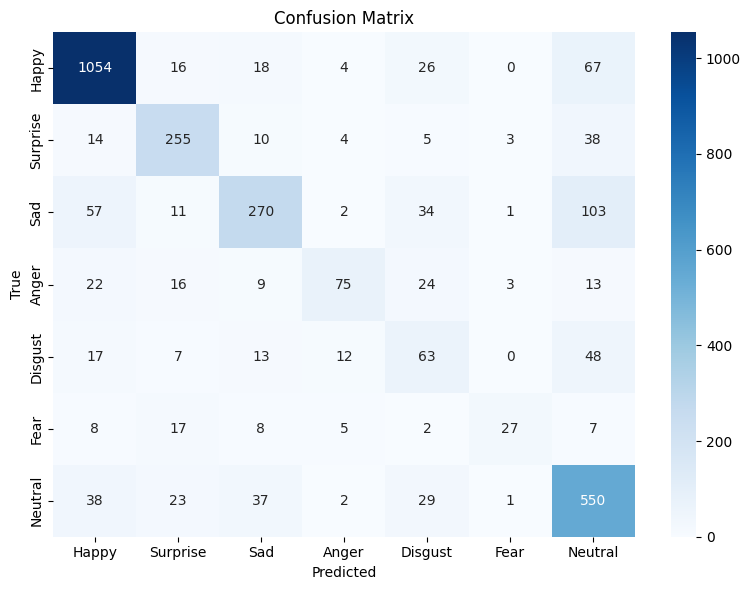

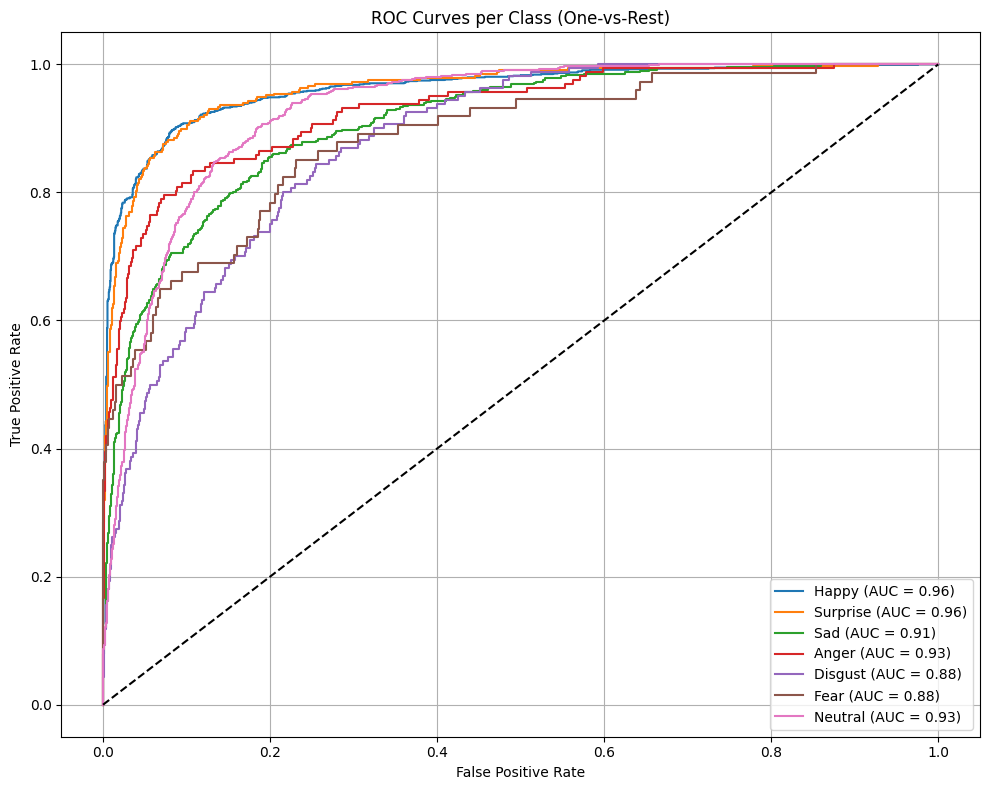

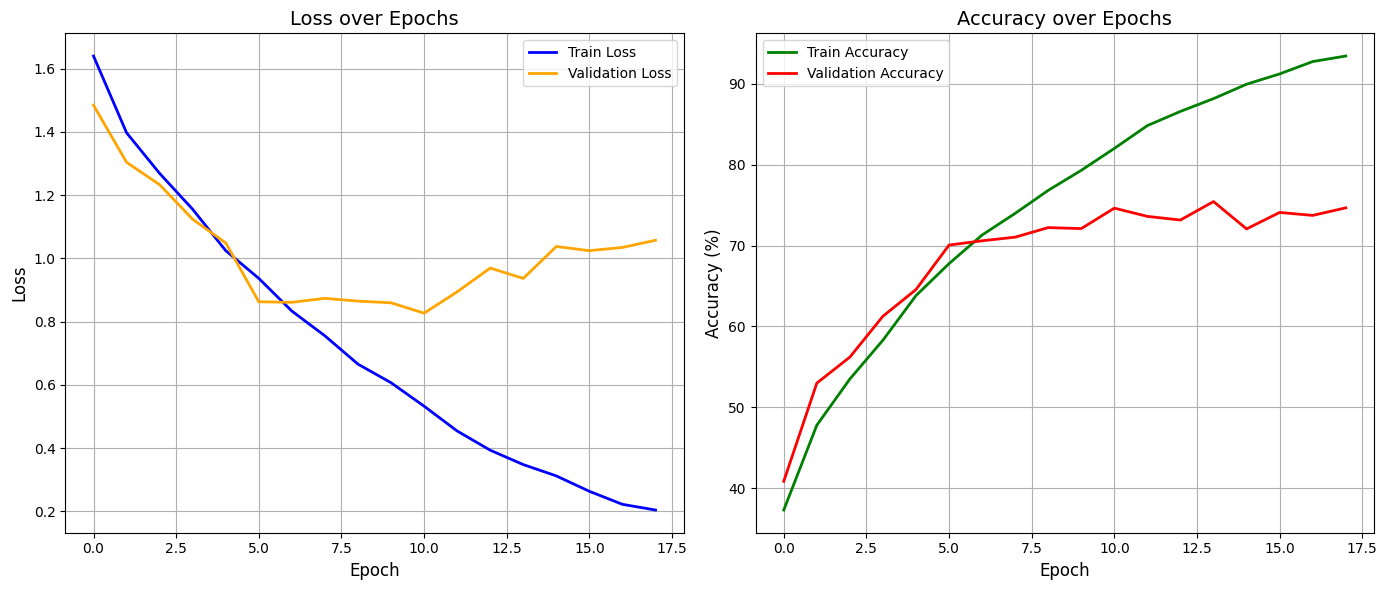

Saved training curves to `/kaggle/working/training_curves.png`


In [7]:
# Evaluate model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load Best Model
best_model_path = "/kaggle/working/best_model.pth"
last_checkpoint_path = "/kaggle/working/checkpoints/checkpoint.pth"

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded best model for evaluation.")
elif os.path.exists(last_checkpoint_path):
    checkpoint = torch.load(last_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded last checkpoint model (best model not found).")
else:
    print("No model found.")
    test_acc = 0.0

# Inference Loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Basic Accuracy
test_acc = 100 * correct / total if total > 0 else 0.0
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
y_true_bin = label_binarize(y_true, classes=range(7))  # 7 classes

# Metrics
precision = precision_score(y_true, y_pred, average='macro') * 100
recall = recall_score(y_true, y_pred, average='macro') * 100
f1 = f1_score(y_true, y_pred, average='macro') * 100
roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')

print(f"\nPrecision (macro): {precision:.2f}%")
print(f"Recall (macro): {recall:.2f}%")
print(f"F1-score (macro): {f1:.2f}%")
print(f"ROC-AUC (macro): {roc_auc:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves per Class (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Step: Visualize plot training curve
if train_losses and val_losses and train_accs and val_accs:
    plt.figure(figsize=(14, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2)
    plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=2)
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", color='green', linewidth=2)
    plt.plot(val_accs, label="Validation Accuracy", color='red', linewidth=2)
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("/kaggle/working/training_curves.png")
    plt.show()
    print("Saved training curves to `/kaggle/working/training_curves.png`")
else:
    print("Training curves not plotted. Lists are empty (training may not have completed).")